# Разработка модели машинного обучения для интернет-магазина "В один клик"

<b>Описание проекта</b>: Интернет-магазин «В один клик» обратился с просьбой разработать модель машинного обучения, которая будет делать персонализированные предложения клиентам.

<b>Цель исследования</b>: Разработать модель машинного обучения, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.

<b>Ход исследования</b>:
* Загрузка данных:
        Загрузка и изучение общей информации из предоставленных датасетов.
* Предобработка данных:
        Обработка пропущенных значений, корректировка типа даных, дубликатов.
* Исследовательский анализ данных:
        Изучение основных параметров объектов, их распределения.
* Объединение таблиц:
        Объединение таблицы market_file.csv, market_money.csv, market_time.csv. 
* Корреляционный анализ:
        Корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования.
* Использование пайплайнов:
        Применение всех изученных моделей, выбор лучшей.
* Анализ важности признаков:
        Оценка важности признаков для лучшей модели и постройте график важности с помощью метода SHAP. 
* Сегментация покупателей:
        Выполнение сегментации покупателей с помощью результатов моделирования и данных о прибыльности покупателей.
* Общий вывод:
        Резюмирование полученных результатов, формулировка ключевых выводов.

In [1]:
!pip install matplotlib==3.5.0 -q

In [2]:
# pip uninstall numpy -y

In [3]:
# pip install numpy==2.0.2

In [4]:
!pip install phik -q
!pip install shap -q
!pip install -Uq scikit-learn

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import phik
import shap

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from phik.report import plot_correlation_matrix
from phik import report
from shap import Explanation, KernelExplainer
from shap.plots import waterfall, beeswarm

## Загрузка данных

In [6]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';')

In [7]:
market_file.columns = market_file.columns.str.lower()
market_money.columns = market_money.columns.str.lower()
market_time.columns = market_time.columns.str.lower()
money.columns = money.columns.str.lower()

### market_file

In [8]:
market_file.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [9]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская активность            1300 non-null   object 
 2   тип сервиса                          1300 non-null   object 
 3   разрешить сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

<b>Были заменены заголовки некоторых столбцов, приведены значения некоторых столбцов к единому регистру.</b>

In [10]:
market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [11]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [12]:
market_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [13]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [14]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [15]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [16]:
money.head()

,id,прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [17]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


Данные загружены. Судя по всему, пропусков в данных нет.

## Предобработка данных

In [18]:
market_file = market_file.rename(columns={'покупательская активность': 'покупательская_активность',
                                          'тип сервиса': 'тип_сервиса', 'разрешить сообщать': 'разрешить_сообщать'})
market_file['покупательская_активность'] = market_file['покупательская_активность'].str.lower()
market_file['популярная_категория'] = market_file['популярная_категория'].str.lower()
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')

Заменён неявный дубликат "стандартт"

In [19]:
money['прибыль'] = money['прибыль'].str.replace(',', '.')

In [20]:
money['прибыль'] = money['прибыль'].astype('float')

In [21]:
market_file.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [22]:
market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [23]:
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

In [24]:
money.isna().sum()

id         0
прибыль    0
dtype: int64

<b>Пропусков не обнаружено.</b>

In [25]:
market_file.duplicated().sum()

0

In [26]:
market_money.duplicated().sum()

0

In [27]:
market_time.duplicated().sum()

0

In [28]:
money.duplicated().sum()

0

<b>Явных дубликатов не обнаружено.</b>

In [29]:
for i in market_file.columns:
    if isinstance(market_file[i][0], str):
        print(market_file[i].unique())

['снизилась' 'прежний уровень']
['премиум' 'стандарт']
['да' 'нет']
['товары для детей' 'домашний текстиль' 'косметика и аксесуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']


In [30]:
for i in market_money.columns:
    if isinstance(market_money[i][0], str):
        print(market_money[i].unique())

['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [31]:
for i in market_time.columns:
    if isinstance(market_time[i][0], str):
        print(market_time[i].unique())

['текущий_месяц' 'предыдущий_месяц']


<b>Неявных дубликатов не обнаружено.</b>

## Исследовательский анализ данных

<b>Уберём пользователей, у которых покупательская активность меньше трёх месяцев.</b>

In [32]:
ids = market_money.loc[market_money['выручка'] == 0, 'id'].unique()
money = money[~money['id'].isin(ids)]
market_file = market_file[~market_file['id'].isin(ids)]
market_money = market_money[~market_money['id'].isin(ids)]
market_time = market_time[~market_time['id'].isin(ids)]

### Гистограмма покупательской активности в market_file

<AxesSubplot:ylabel='покупательская_активность'>

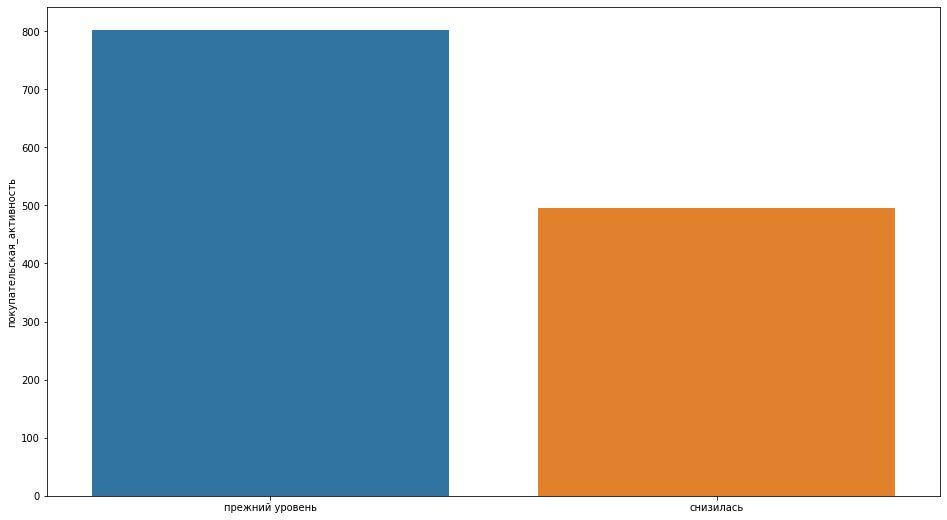

In [33]:
plt.figure(figsize=(16, 9))
sns.barplot(x=market_file['покупательская_активность'].value_counts().index,
            y=market_file['покупательская_активность'].value_counts())

<b>Больше пользователей, у которых покупательская активность осталась на прежнем уровне.</b>

### Гистограмма типа сервиса в market_file

<AxesSubplot:ylabel='тип_сервиса'>

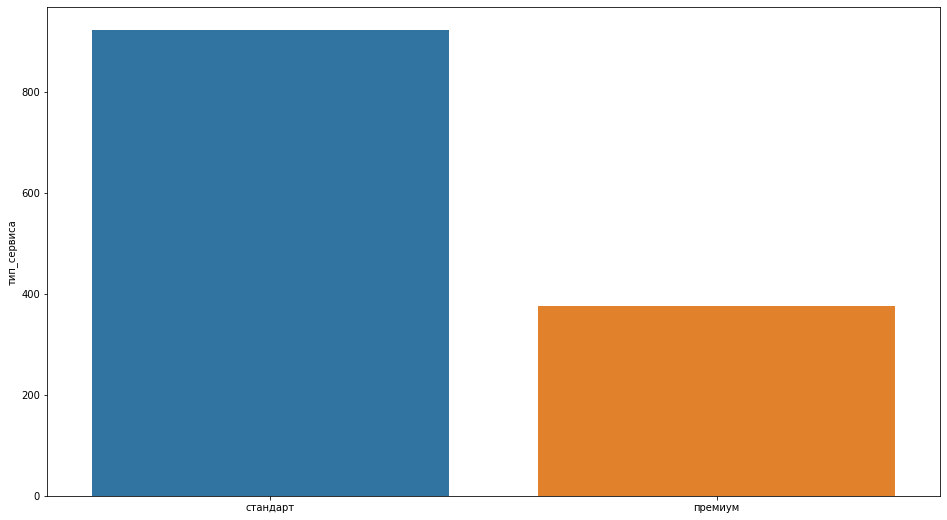

In [34]:
plt.figure(figsize=(16, 9))
sns.barplot(x=market_file['тип_сервиса'].value_counts().index,
            y=market_file['тип_сервиса'].value_counts())

<b>У большинства пользователей стандартный тип сервиса.</b>

### Гистограмма столбца "разрешить_сообщить" в market_file

<AxesSubplot:ylabel='разрешить_сообщать'>

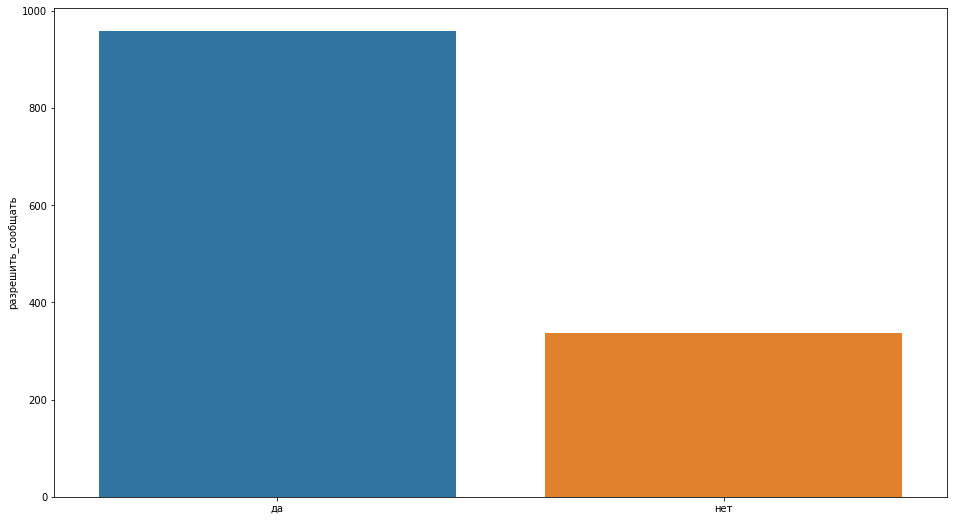

In [35]:
plt.figure(figsize=(16, 9))
sns.barplot(x=market_file['разрешить_сообщать'].value_counts().index,
            y=market_file['разрешить_сообщать'].value_counts())

<b>Большинство пользователей разрешает сообщать дополнительную информацию о товаре.</b>

### Гистограмма столбца "маркет__актив_6_ мес" в market_file

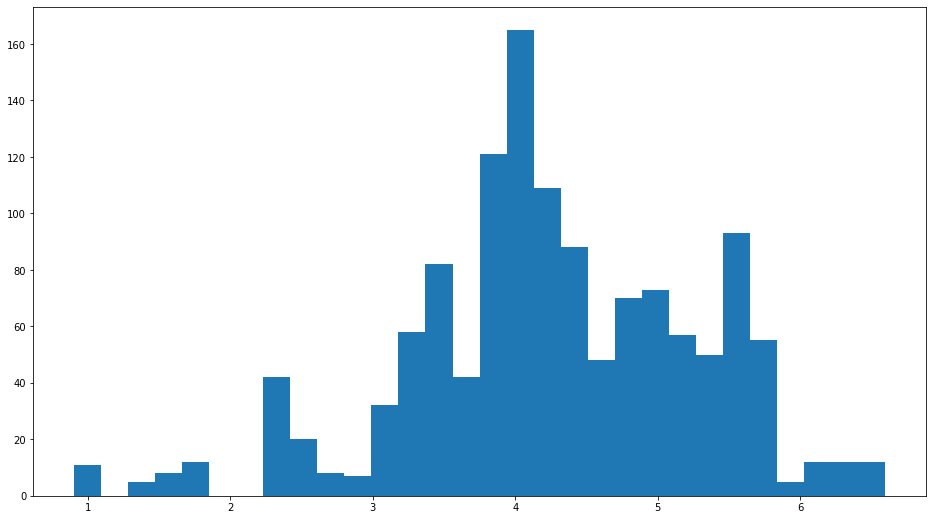

In [36]:
plt.figure(figsize=(16, 9))
plt.hist(market_file['маркет_актив_6_мес'], bins=30);

<AxesSubplot:>

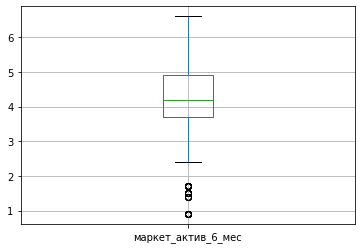

In [37]:
market_file.boxplot('маркет_актив_6_мес')

### Гистограмма столбца "маркет_актив_тек_мес" в market_file

<AxesSubplot:ylabel='маркет_актив_тек_мес'>

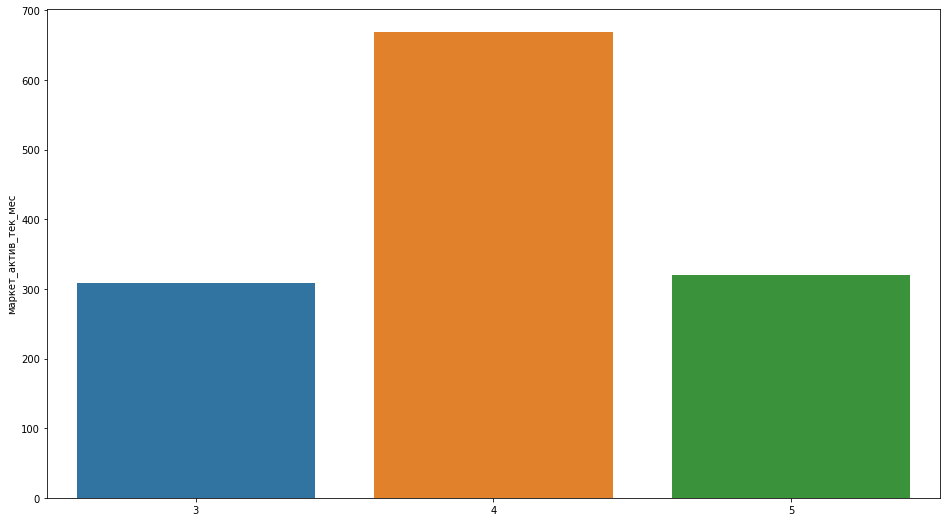

In [38]:
plt.figure(figsize=(16, 9))
sns.barplot(x=market_file['маркет_актив_тек_мес'].value_counts().index,
            y=market_file['маркет_актив_тек_мес'].value_counts())

<b>Самое частое количество коммуникаций за текущий месяц - 4</b>

### Гистограмма столбца "длительность" в market_file

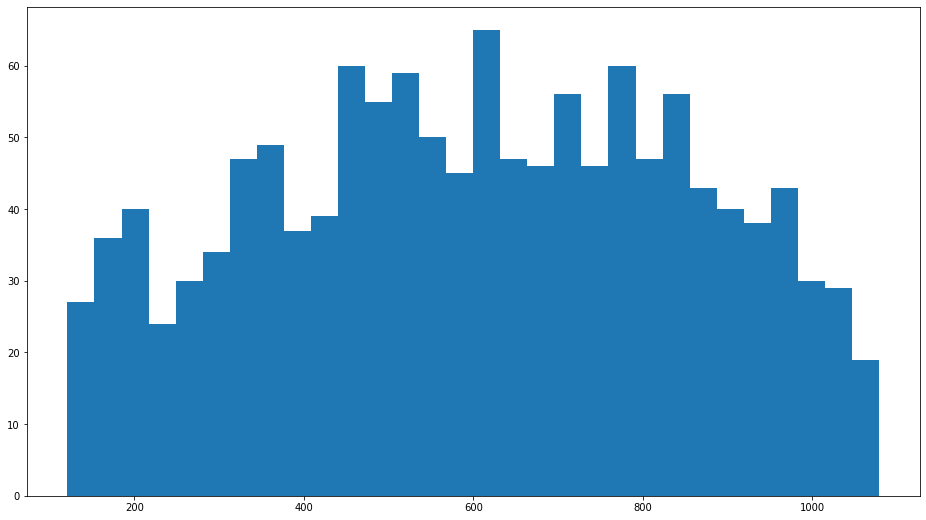

In [39]:
plt.figure(figsize=(16, 9))
plt.hist(market_file['длительность'], bins=30);

<AxesSubplot:>

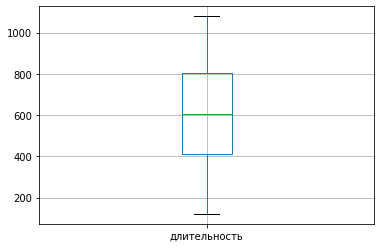

In [40]:
market_file.boxplot('длительность')

### Гистограмма столбца "акционные_покупки" в market_file

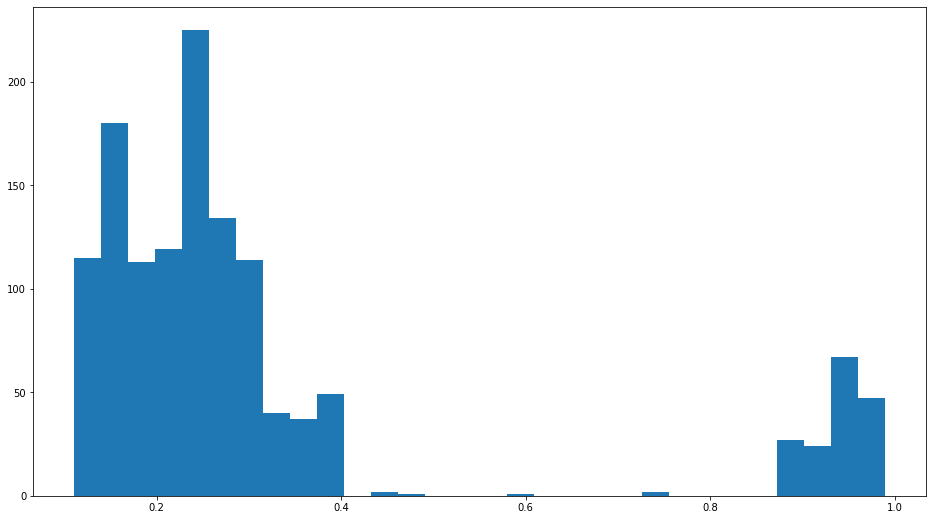

In [41]:
plt.figure(figsize=(16, 9))
plt.hist(market_file['акционные_покупки'], bins=30);

<AxesSubplot:>

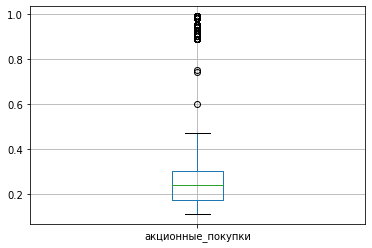

In [42]:
market_file.boxplot('акционные_покупки')

### Гистограмма столбца "популярная_категория" в market_file

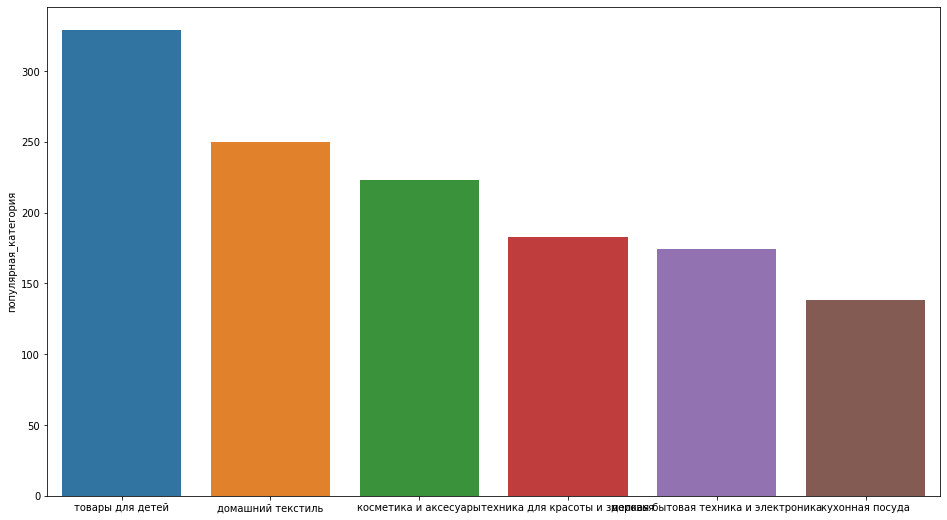

In [43]:
plt.figure(figsize=(16, 9))
sns.barplot(x=market_file['популярная_категория'].value_counts().index,
            y=market_file['популярная_категория'].value_counts());

<b>Самая популярная категория - товары для детей.</b>

### Гистограмма столбца "средний_просмотр_категорий_за_визит" в market_file

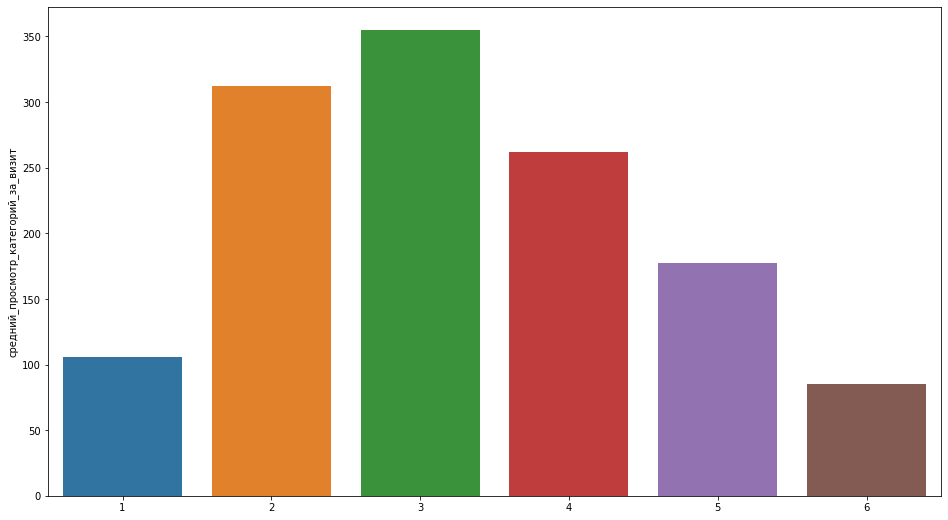

In [44]:
plt.figure(figsize=(16, 9))
sns.barplot(x=market_file['средний_просмотр_категорий_за_визит'].value_counts().index,
            y=market_file['средний_просмотр_категорий_за_визит'].value_counts());

<b>Чаще всего просматривают по 3 категории за визит</b>

### Гистограмма столбца "неоплаченные_продукты_штук_квартал" в market_file

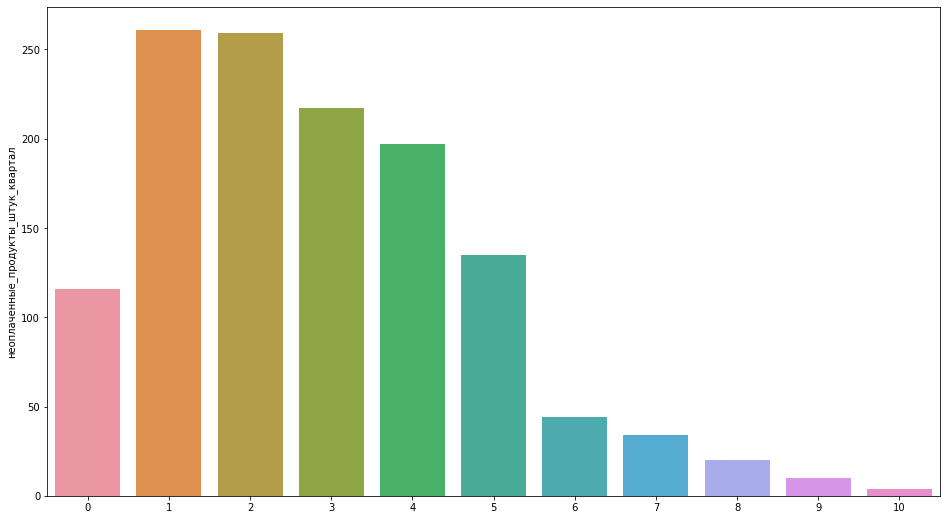

In [45]:
plt.figure(figsize=(16, 9))
sns.barplot(x=market_file['неоплаченные_продукты_штук_квартал'].value_counts().index,
            y=market_file['неоплаченные_продукты_штук_квартал'].value_counts());

<b>Самое частое количество неоплаченных товаров в корзине за 3 месяца - 1 и 2.</b>

### Гистограмма столбца "ошибка_сервиса" в market_file

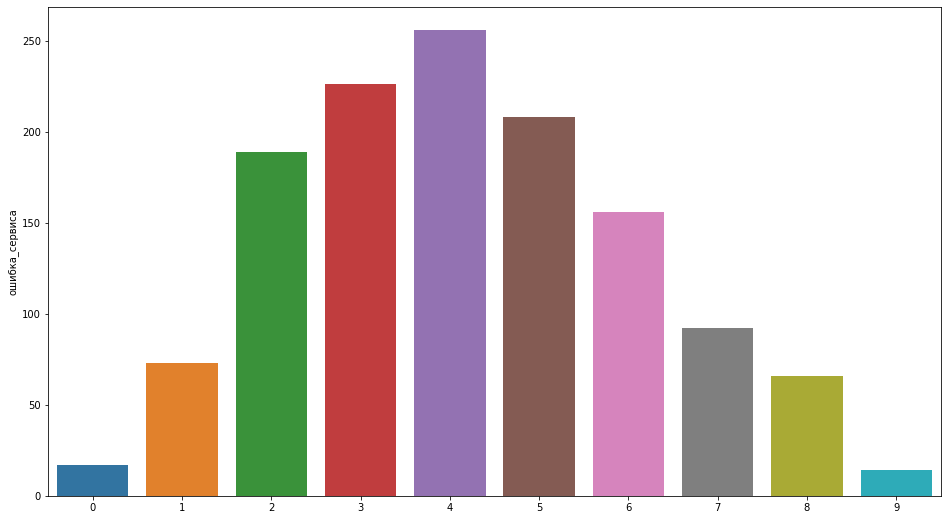

In [46]:
plt.figure(figsize=(16, 9))
sns.barplot(x=market_file['ошибка_сервиса'].value_counts().index,
            y=market_file['ошибка_сервиса'].value_counts());

<b>Самое частое количество ошибок сервиса - 4.</b>

### Гистограмма столбца "страниц_за_визит" в market_file

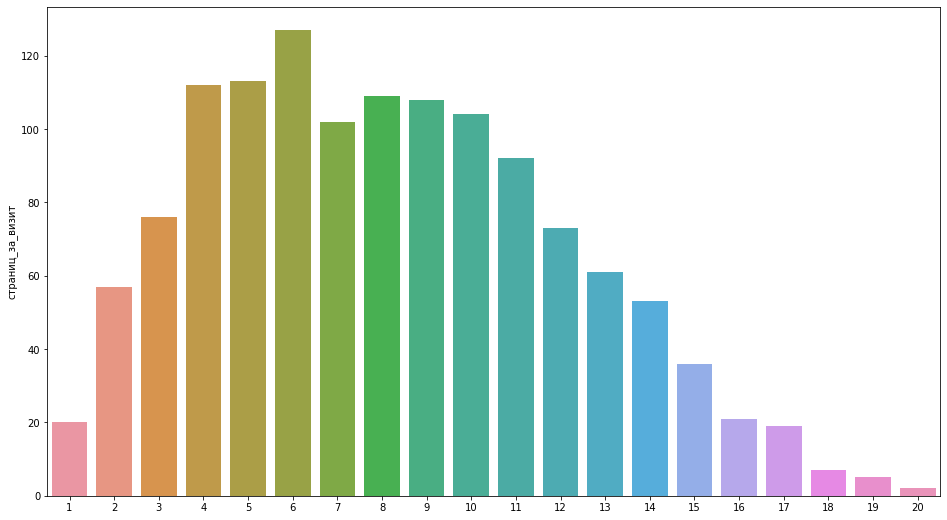

In [47]:
plt.figure(figsize=(16, 9))
sns.barplot(x=market_file['страниц_за_визит'].value_counts().index,
            y=market_file['страниц_за_визит'].value_counts());

<b>Самое частое количество просмотренных страниц за визит - 6.</b>

### Гистограмма столбца "выручка" в market_money

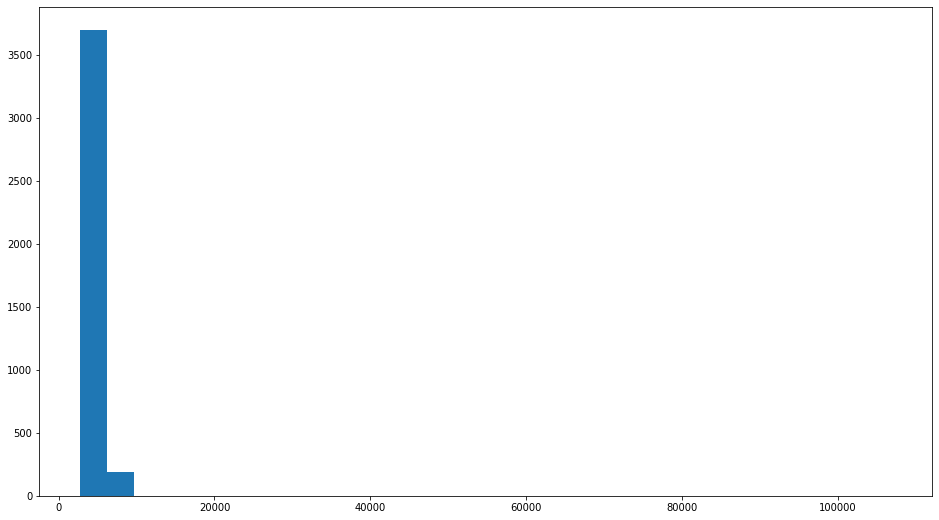

In [48]:
plt.figure(figsize=(16, 9))
plt.hist(market_money['выручка'], bins=30);

<AxesSubplot:>

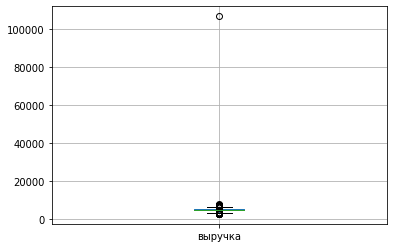

In [49]:
market_money.boxplot('выручка')

In [50]:
market_money[market_money['выручка'] > 100000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [51]:
market_money.head()

,id,период,выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4


<b>Пользователь с id 215380 потратил больше 100000 на сайте за текущий месяц. Возможно, он просто постоянный и богатый клиент, не вижу смысла его удалять.</b>

In [52]:
market_money = market_money.drop(index=market_money[market_money['выручка'] > 100000].index)

In [53]:
market_money.head()

,id,период,выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4


In [54]:
market_money[market_money['id'] == 215380]

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0


In [55]:
market_money = market_money.drop(index=market_money[market_money['id'] == 215380].index)

<b>С другой стороны, два предыдущих месяца он не тратил настолько много денег. Может, он внезапно разбогател?</b>

### Гистограмма столбца "минут" в market_time

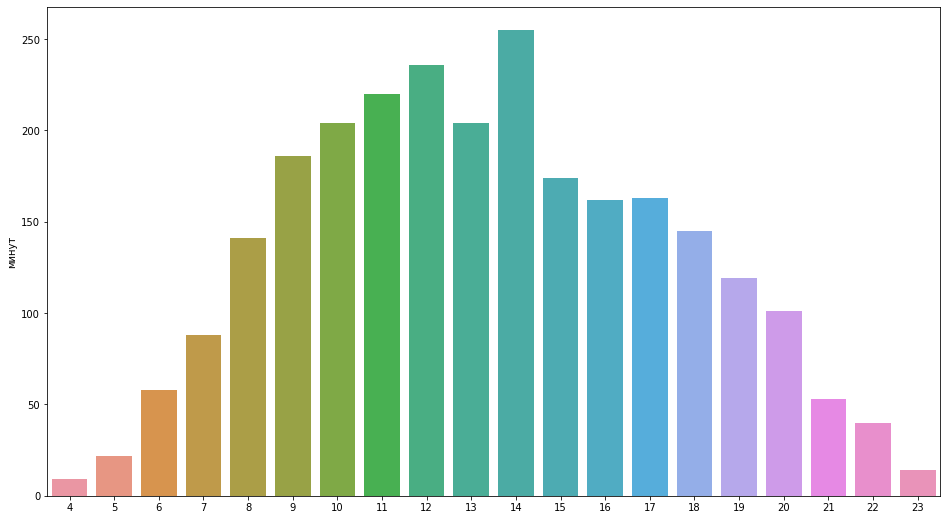

In [56]:
plt.figure(figsize=(16, 9))
sns.barplot(x=market_time['минут'].value_counts().index,
            y=market_time['минут'].value_counts());

<b>Чаще всего на сайте проводят около 14 минут.</b>

### Гистограмма столбца "прибыль" в money

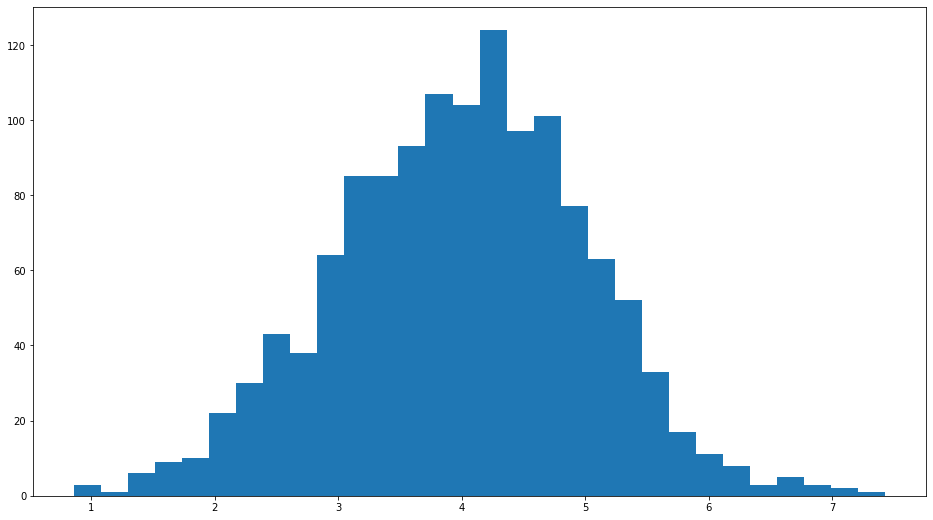

In [57]:
plt.figure(figsize=(16, 9))
plt.hist(money['прибыль'], bins=30);

<AxesSubplot:>

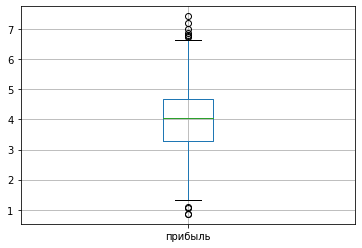

In [58]:
money.boxplot('прибыль')

<b>В этом пункте мы построили графики для каждого из признаков и проанализировали их. Было удалено одно аномальное значение. </b>

## Объединение таблиц

In [59]:
arranged_income = market_money.pivot_table(index='id', columns='период', values='выручка').reset_index()
arranged_income.columns.name = None

In [60]:
arranged_income

,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5
...,...,...,...,...
1291,216643,3664.0,4704.0,4741.7
1292,216644,4729.0,5299.0,5353.0
1293,216645,5160.0,5334.0,5139.2
1294,216646,4923.0,4725.0,5224.6


In [61]:
arranged_time = market_time.pivot_table(index='id', columns='период', values='минут').reset_index()
arranged_time.columns.name = None
arranged_time = arranged_time.rename(columns={'предыдущий_месяц': 'предыдущий_месяц_минут', 'текущий_месяц': 'текущий_месяц_минут'})

In [62]:
arranged_time

,id,предыдущий_месяц_минут,текущий_месяц_минут
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10
...,...,...,...
1292,216643,14,7
1293,216644,12,11
1294,216645,12,18
1295,216646,18,7


In [63]:
arranged_income = arranged_income.merge(arranged_time, on='id')
arranged_income

,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,предыдущий_месяц_минут,текущий_месяц_минут
0,215349,5216.0,4472.0,4971.6,12,10
1,215350,5457.5,4826.0,5058.4,8,13
2,215351,6158.0,4793.0,6610.4,11,13
3,215352,5807.5,4594.0,5872.5,8,11
4,215353,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...
1291,216643,3664.0,4704.0,4741.7,14,7
1292,216644,4729.0,5299.0,5353.0,12,11
1293,216645,5160.0,5334.0,5139.2,12,18
1294,216646,4923.0,4725.0,5224.6,18,7


In [64]:
market_file = market_file.merge(arranged_income)

In [65]:
market_file

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,предыдущий_месяц_минут,текущий_месяц_минут
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,216643,прежний уровень,стандарт,да,6.6,3,318,0.24,техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1292,216644,прежний уровень,стандарт,нет,5.1,4,454,0.21,домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1293,216645,прежний уровень,стандарт,да,4.1,3,586,0.20,домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1294,216646,прежний уровень,стандарт,да,6.3,5,645,0.12,техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


<b>Таблицы объединены.</b>

## Корреляционный анализ

### Матрица корреляции

In [66]:
market_file.drop('id', axis=1).phik_matrix(interval_cols=['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 
                                                          'акционные_покупки', 'средний_просмотр_категорий_за_визит', 
                                                          'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 
                                                          'страниц_за_визит', 'предыдущий_месяц', 'препредыдущий_месяц',
                                                          'текущий_месяц', 'предыдущий_месяц_минут', 'текущий_месяц_минут'])

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,предыдущий_месяц_минут,текущий_месяц_минут
покупательская_активность,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.505655,0.224154,0.749888,0.224638,0.497393,0.197213,0.685138,0.576770
тип_сервиса,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.120027,0.079515,0.102594,0.000000,0.069704,0.124216,0.131814,0.000000
разрешить_сообщать,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.195982,0.021839,0.042134,0.080842,0.000000,0.060907,0.038387,0.000000
маркет_актив_6_мес,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.289421,0.142401,0.396769,0.155476,0.315331,0.039795,0.363950,0.330601
маркет_актив_тек_мес,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.144203,0.116946,0.000000,0.051824,0.000000,0.000000,0.107945,0.061410
длительность,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.192611,0.175608,0.122495,0.125572,0.113200,0.147048,0.026448,0.101481
акционные_покупки,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.237962,0.000000,0.311418,0.060733,0.226381,0.071094,0.262324,0.250558
популярная_категория,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.248620,0.000000,0.160300,0.252097,0.043528,0.237240,0.195233,0.089883
средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.325578,0.070315,0.262271,0.098440,0.176828,0.092597,0.159837,0.182568
неоплаченные_продукты_штук_квартал,0.505655,0.120027,0.195982,0.289421,0.144203,0.192611,0.237962,0.248620,0.325578,1.000000,0.032907,0.363760,0.249171,0.261016,0.230022,0.256632,0.232383


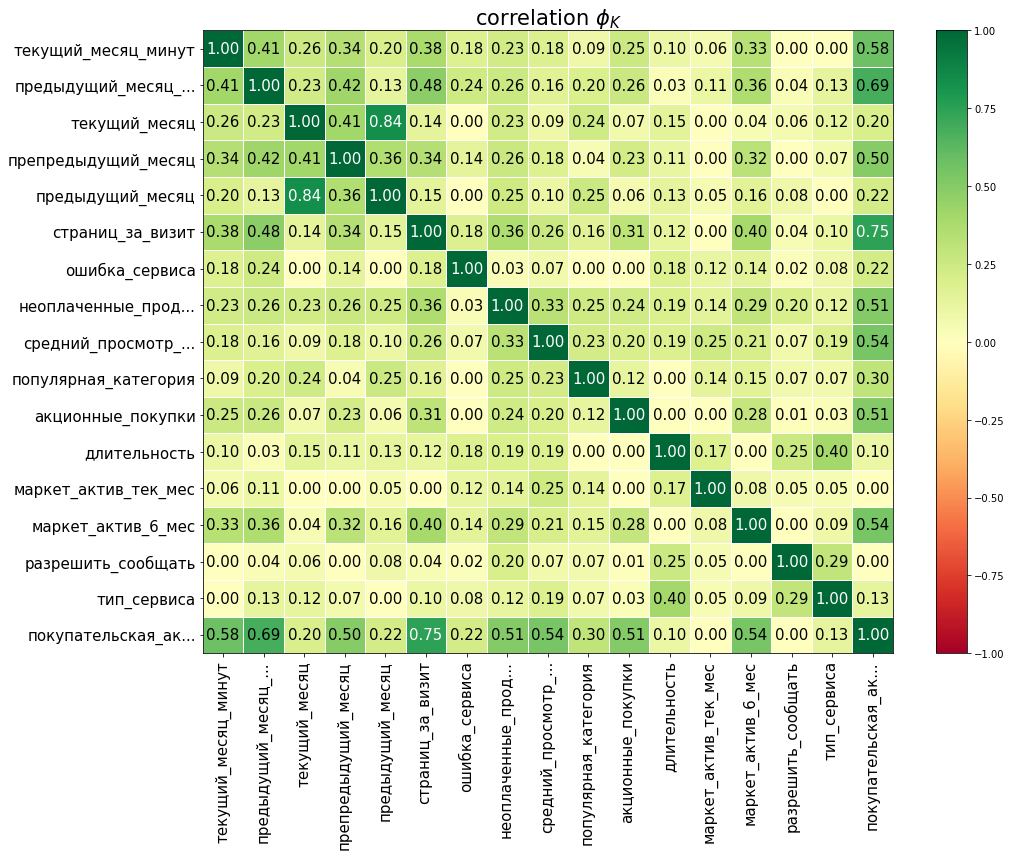

In [67]:
# список интервальных признаков
interval_cols = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 
                 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 
                 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 
                 'страниц_за_визит', 'предыдущий_месяц', 'препредыдущий_месяц',
                 'текущий_месяц', 'предыдущий_месяц_минут', 'текущий_месяц_минут']

# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = market_file.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

<b>Проанализировав таблицу, можем сказать, что покупательская активность сильнее всего коррелирует со столбцом маркет актив_6_мес, акционные_покупки, средний_просмотр_категорий_за_визит, неоплаченные_продукты_штук_квартал, страниц_за_визит, предыдущий_месяц_минут, текущий_месяц_минут. Мультиколлинеарности не обнаружено.</b>

## Использование пайплайнов

In [68]:
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
               'средний_просмотр_категорий_за_визит', 
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 
               'страниц_за_визит', 'предыдущий_месяц', 'препредыдущий_месяц',
               'текущий_месяц', 'предыдущий_месяц_минут', 'текущий_месяц_минут']
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
RANDOM_STATE = 42

y = market_file['покупательская_активность']
X = market_file.drop(['покупательская_активность'], axis=1)
X.set_index('id', inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [69]:
X_train

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,предыдущий_месяц_минут,текущий_месяц_минут
id,,,,,,,,,,,,,,,,
216580,стандарт,да,4.3,4,514,0.11,домашний текстиль,3,3,3,9,5400.0,4818.0,6034.4,19,13
215897,стандарт,да,3.9,4,627,0.24,товары для детей,3,3,7,8,5004.5,4460.0,5606.4,17,12
215618,стандарт,нет,4.1,5,657,0.35,товары для детей,2,6,2,4,5612.5,4441.0,6103.9,10,7
215679,стандарт,нет,5.5,3,712,0.95,домашний текстиль,2,0,6,11,4541.0,5315.0,5341.8,18,18
216150,стандарт,да,4.3,4,283,0.11,кухонная посуда,3,4,5,14,5789.0,4979.0,6621.0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216396,премиум,да,5.4,4,723,0.15,техника для красоты и здоровья,5,3,2,11,5378.0,4603.0,4835.9,14,17
216447,премиум,да,5.5,5,953,0.24,домашний текстиль,2,2,4,14,5501.0,5171.0,5917.0,12,14
216482,стандарт,да,5.6,3,660,0.24,домашний текстиль,5,3,4,9,5310.5,5186.0,5548.4,10,9


In [70]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 216580 to 216478
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   тип_сервиса                          972 non-null    object 
 1   разрешить_сообщать                   972 non-null    object 
 2   маркет_актив_6_мес                   972 non-null    float64
 3   маркет_актив_тек_мес                 972 non-null    int64  
 4   длительность                         972 non-null    int64  
 5   акционные_покупки                    972 non-null    float64
 6   популярная_категория                 972 non-null    object 
 7   средний_просмотр_категорий_за_визит  972 non-null    int64  
 8   неоплаченные_продукты_штук_квартал   972 non-null    int64  
 9   ошибка_сервиса                       972 non-null    int64  
 10  страниц_за_визит                     972 non-null    int64  
 11  предыдущий_месяц        

In [72]:
X.isna().sum()

тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
предыдущий_месяц                       0
препредыдущий_месяц                    0
текущий_месяц                          0
предыдущий_месяц_минут                 0
текущий_месяц_минут                    0
dtype: int64

In [73]:
label_encoder = LabelEncoder()

In [74]:
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [75]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse_output =False)
        )
    ]
)

In [76]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'] 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [77]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [78]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [79]:
param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__degree': range(1, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [80]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer...
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__degree': range(1, 4),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__solver': ['newton-cg',
                                                            'lbfgs',
                                                            'liblinear', 'sag',
                                                            'saga'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

<b>Была выбрана метрика ROC-AUC, потому что она оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения. Она не зависит от того, какой будет выбран порог, это самая общая оценка работы модели.</b>

In [81]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strateg...
                                                 ('num', StandardScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит',
                                                   'предыдущий_месяц',
                                                   'препредыдущий_месяц',
                                                   'текущий_месяц',
                                                   'предыдущий_месяц_минут',
                                                   'текущий_месяц_минут'])])),
                ('models', KNeighborsClassifier(n_neighbors=16))])

In [82]:
randomized_search.best_score_

0.909172637060246

In [83]:
X.isna().sum()

тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
предыдущий_месяц                       0
препредыдущий_месяц                    0
текущий_месяц                          0
предыдущий_месяц_минут                 0
текущий_месяц_минут                    0
dtype: int64

In [84]:
y_predict = randomized_search.predict(X_test)
y_predict_proba = randomized_search.predict_proba(X_test)

In [85]:
X_test.isna().sum()

тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
предыдущий_месяц                       0
препредыдущий_месяц                    0
текущий_месяц                          0
предыдущий_месяц_минут                 0
текущий_месяц_минут                    0
dtype: int64

In [86]:
roc_auc_score(y_test, y_predict_proba[:, 1])

0.9009539842873177

<b>KNeighborsClassifier(n_neighbors=16) - лучшая модель, значение метрики roc_auc - 0.910867507238927. Была выбрана метрика ROC-AUC, потому что она оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения. Она не зависит от того, какой будет выбран порог, это самая общая оценка работы модели.</b>

## Анализ важности признаков

In [87]:
shap.initjs()
X_train_shap = pd.DataFrame(
    randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_train),
    columns = randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
)

X_test_shap = pd.DataFrame(
    randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test), 
    columns = randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
)

knn = randomized_search.best_estimator_.named_steps['models']
explainer = shap.KernelExplainer(knn.predict, X_train_shap)
shap_values = explainer(shap.sample(X_test_shap, 10))

Using 972 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/10 [00:00<?, ?it/s]

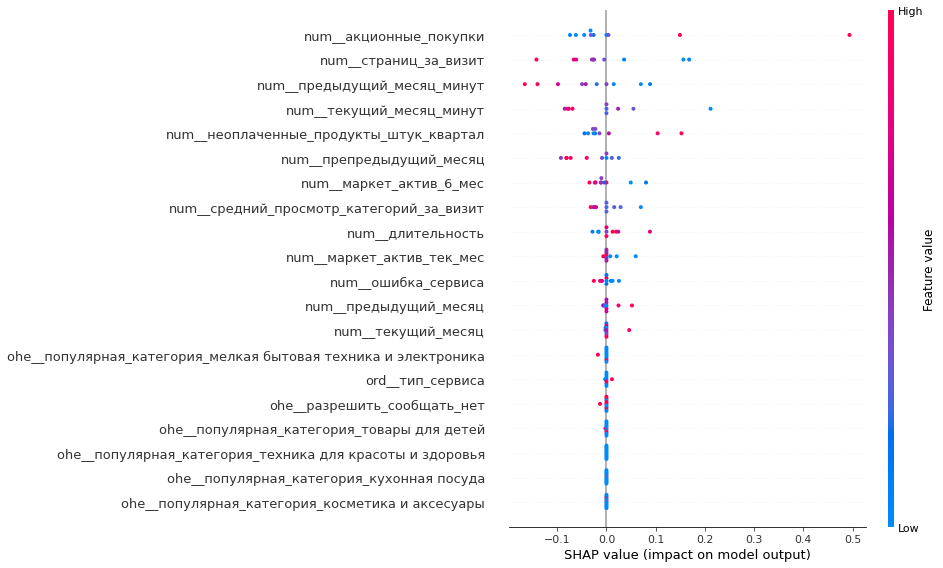

In [88]:
shap.plots.beeswarm(shap_values, max_display=21)

<b>Низкое значение признака "акционные_покупки" снижает вероятность того, что покупательская способность останется на прежнем уровне. Высокое значение признака "предыдущий_месяц_минут" снижает вероятносто того, что </b>

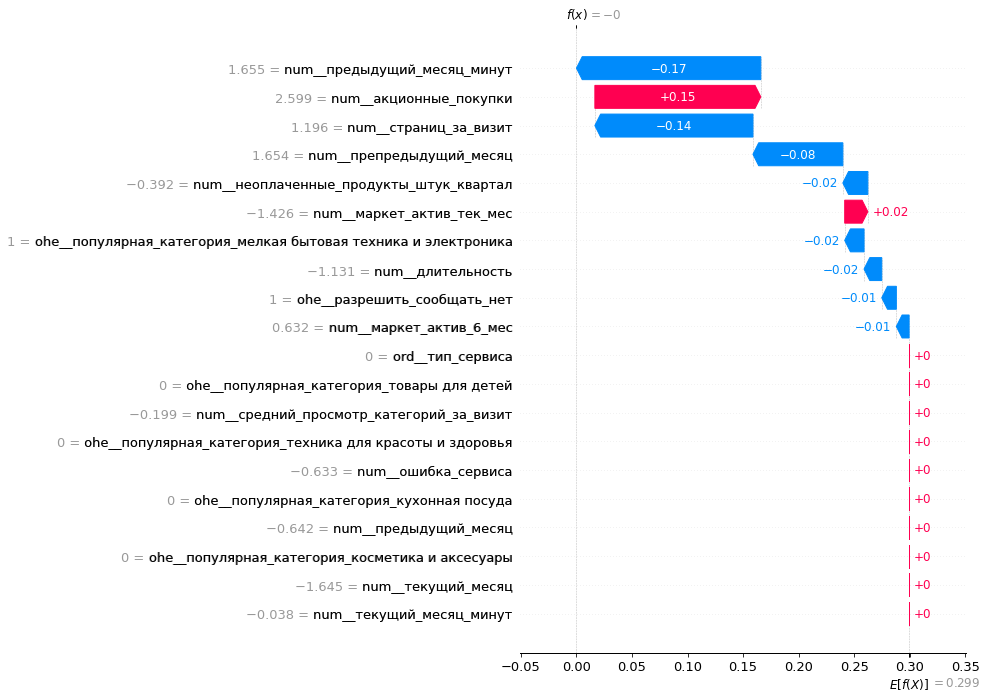

In [89]:
shap.plots.waterfall(shap_values[8], max_display=21)

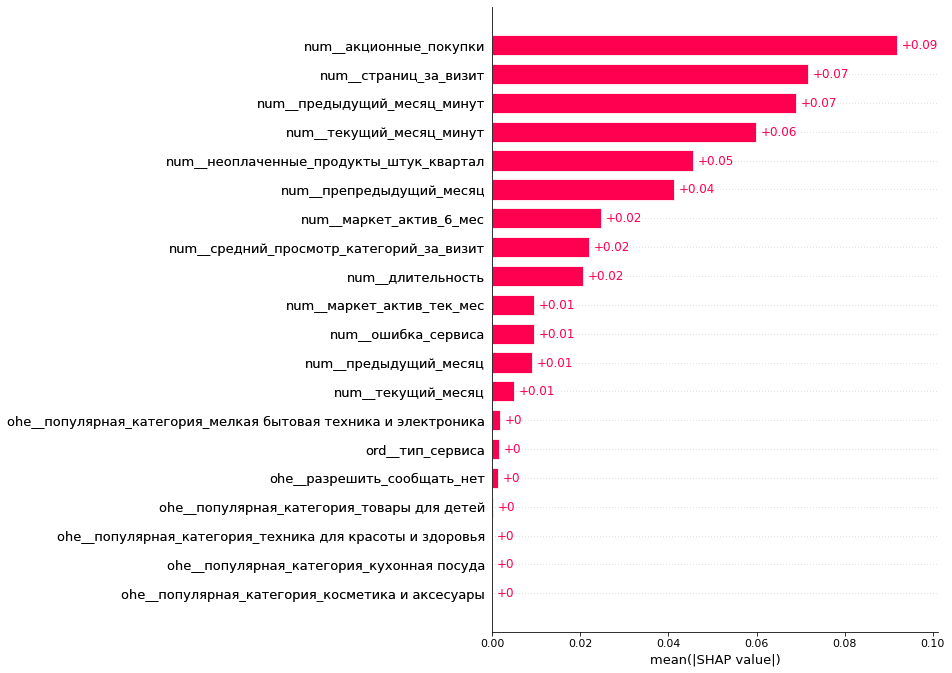

In [90]:
shap.plots.bar(shap_values, max_display=21)

<b>По значимости лидирует признак "акционные покупки", на втором и третьем месте находятся признаки "страниц за визит" и "предыдущий_месяц_минут".</b>

<b>Наиболее значимые признаки:</b>
* акционные_покупки
* страниц_за_визит
* предыдущий_месяц

<b>Наименее значимые признаки:</b>
* популярная_категория_косметика и аксесуары
* популярная_техника_для красоты и здоровья
* популярная_категория_кухонная посуда

<b>Как можно использовать эти наблюдения при моделировании и принятии бизнес-решений:</b>
* Так как у признака "акционные_покупки" очень большое влияние, можно предложить компании проводить больше акций
* У признака "страниц_за_визит" большое влияние, может, возможно как-нибудь заинтересовать пользователя, чтобы он просматривал больше страниц.
* У признака "предыдущий_месяц" тоже неслабое влияние. Этот признак показывает, сколько минут пользователь провёл на сайте в предыдущем месяце. Нужно как-то заинтересовать пользователя, чтобы он проводил больше времени на сайте.

## Сегментация пользователей

In [91]:
predictions = randomized_search.predict_proba(X)[:, 1]
X['вероятность_снижения'] = predictions
merged = X.merge(money, on = 'id')
merged.head()

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,предыдущий_месяц_минут,текущий_месяц_минут,вероятность_снижения,прибыль
0,215349,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,1.0000,4.16
1,215350,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,0.3750,3.13
2,215351,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,0.9375,4.87
3,215352,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,0.9375,4.21
4,215353,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,0.6875,3.95


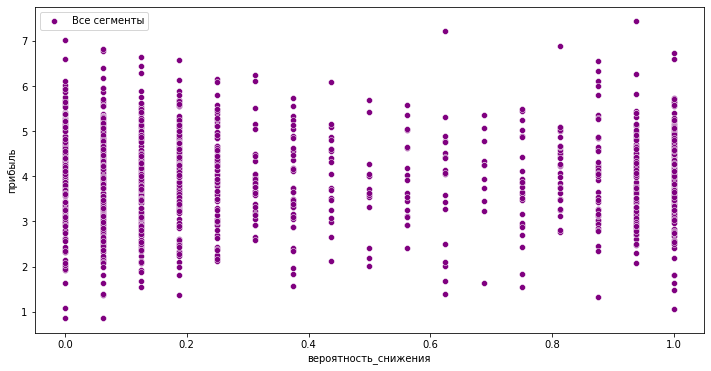

In [92]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged, x='вероятность_снижения', y='прибыль', label='Все сегменты', color='purple')
plt.show()

<b>Выделим сегмент, у которого прибыль будет выше среднего, и которого вероятность снижения покупательской активности будет высокой.</b>

In [93]:
segment = merged[(merged['вероятность_снижения'] >= 0.6) & (merged['прибыль'] >= merged['прибыль'].mean())]
segment.head()

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,предыдущий_месяц_минут,текущий_месяц_минут,вероятность_снижения,прибыль
0,215349,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,1.0000,4.16
2,215351,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,0.9375,4.87
3,215352,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,0.9375,4.21
7,215356,стандарт,да,4.2,4,192,0.14,косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7,1.0000,4.93
17,215368,премиум,да,3.8,5,829,0.24,техника для красоты и здоровья,2,2,6,1,5823.0,4536.0,5591.6,11,9,0.9375,6.27


<b>Посмотрим на матрицу корелляции датасета</b>

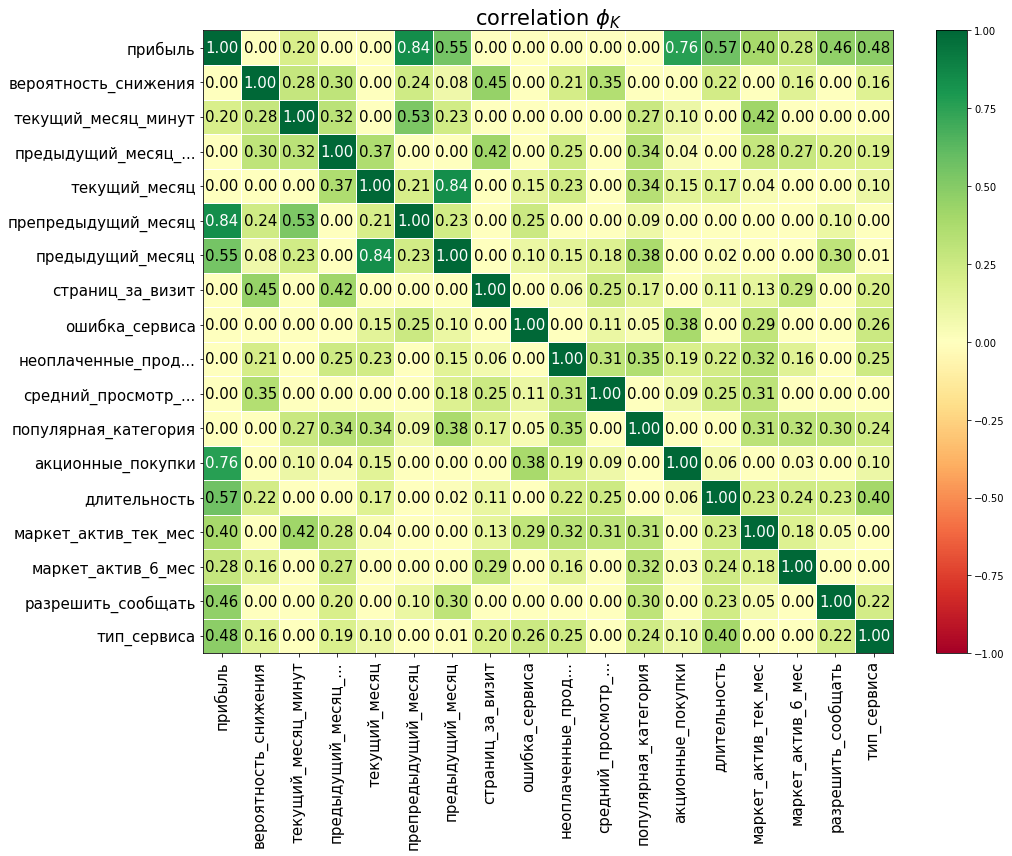

In [94]:
# список интервальных признаков
interval_cols = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 
                 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 
                 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 
                 'страниц_за_визит', 'предыдущий_месяц', 'препредыдущий_месяц',
                 'текущий_месяц', 'предыдущий_месяц_минут', 'текущий_месяц_минут']

# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = segment.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

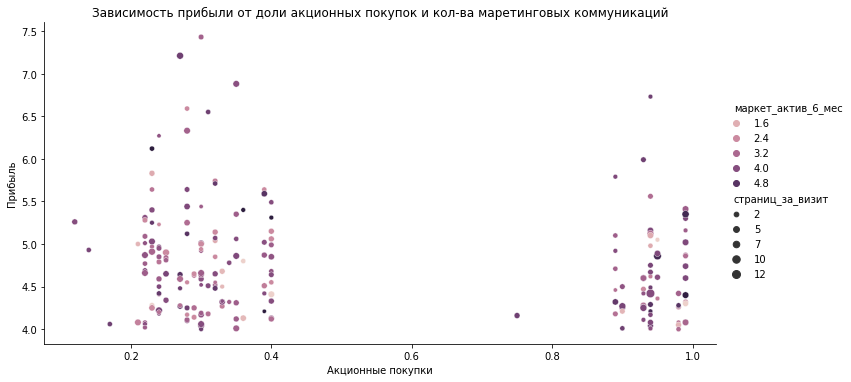

In [95]:
sns.relplot(data = segment, x = 'акционные_покупки', y ='прибыль', hue = 'маркет_актив_6_мес', size = 'страниц_за_визит', aspect = 2)
plt.title('Зависимость прибыли от доли акционных покупок и кол-ва маретинговых коммуникаций')
plt.xlabel('Акционные покупки')
plt.ylabel('Прибыль')
plt.show()

In [96]:
segment.pivot_table(index = ['страниц_за_визит', 'тип_сервиса'])

id  акционные_покупки  \
страниц_за_визит тип_сервиса                                     
1                премиум      215418.666667           0.273333   
                 стандарт     215524.875000           0.450000   
2                премиум      215606.400000           0.390000   
                 стандарт     215565.333333           0.570667   
3                премиум      215529.454545           0.408182   
                 стандарт     215578.153846           0.461154   
4                премиум      215540.230769           0.448462   
                 стандарт     215578.840000           0.606000   
5                премиум      215558.933333           0.418667   
                 стандарт     215572.882353           0.507059   
6                премиум      215692.545455           0.592727   
                 стандарт     215580.300000           0.566000   
7                премиум      215594.333333           0.413333   
                 стандарт     215780.100000           0.589000   
8                премиум      215535.500000           0.595000   
                 стандарт     215938.000000           0.514000   
9                стандарт     215927.000000           0.990000   
11               премиум      216413.000000           0.950000   
14               стандарт     215801.000000           0.940000   

                              вероятность_снижения  длительность  \
страниц_за_визит тип_сервиса                                       
1                премиум                  0.958333    767.333333   
                 стандарт                 0.953125    587.750000   
2                премиум                  0.962500    510.000000   
                 стандарт                 0.972917    531.166667   
3                премиум                  0.954545    625.454545   
                 стандарт                 0.925481    563.576923   
4                премиум                  0.951923    694.538462   
                 стандарт                 0.882500    542.400000   
5                премиум                  0.920833    821.000000   
                 стандарт                 0.875000    573.352941   
6                премиум                  0.875000    779.818182   
                 стандарт                 0.937500    559.600000   
7                премиум                  0.868056    807.333333   
                 стандарт                 0.818750    652.600000   
8                премиум                  0.875000    834.000000   
                 стандарт                 0.775000    651.200000   
9                стандарт                 0.687500    801.000000   
11               премиум                  0.750000   1032.000000   
14               стандарт                 0.625000    479.000000   

                              маркет_актив_6_мес  маркет_актив_тек_мес  \
страниц_за_визит тип_сервиса                                             
1                премиум                4.300000              4.333333   
                 стандарт               3.350000              3.875000   
2                премиум                3.900000              4.200000   
                 стандарт               3.533333              4.200000   
3                премиум                3.418182              4.181818   
                 стандарт               3.546154              4.115385   
4                премиум                3.238462              4.384615   
                 стандарт               3.368000              4.080000   
5                премиум                3.420000              4.000000   
                 стандарт               3.276471              3.647059   
6                премиум                3.727273              4.000000   
                 стандарт               3.360000              4.300000   
7                премиум                3.588889              3.777778   
                 стандарт               3.680000              3.900000   
8                премиум                2

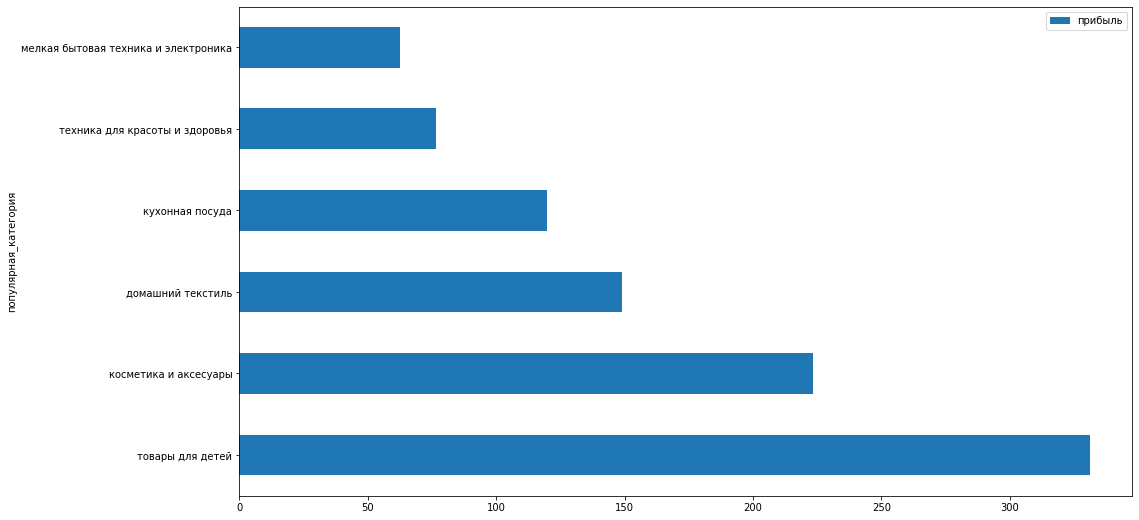

In [97]:
segment.groupby('популярная_категория')['прибыль'].sum().sort_values(ascending = False).plot(kind = 'barh', legend = True, figsize = (16, 9));

<b>Больше всего прибыли у сегментированной группы приносят товары для детей, меньше всего - мелкая бытовая техника и электроника.</b>

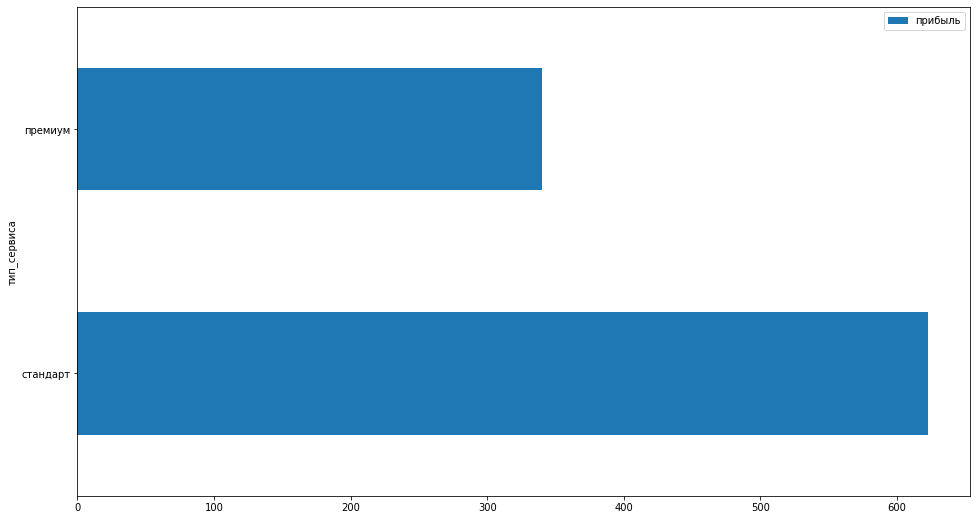

In [98]:
segment.groupby('тип_сервиса')['прибыль'].sum().sort_values(ascending = False).plot(kind = 'barh', legend = True, figsize = (16, 9));

<b>Больше всего прибыли в сегментированной группы приносят пользователи со стандартным типом сервиса.</b>

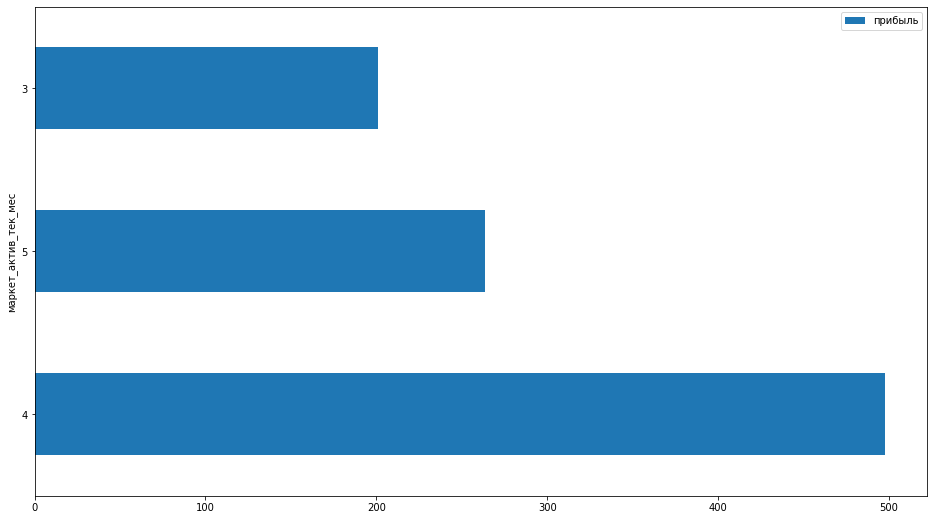

In [99]:
segment.groupby('маркет_актив_тек_мес')['прибыль'].sum().sort_values(ascending = False).plot(kind = 'barh', legend = True, figsize = (16, 9));

<b>Больше всего прибыли у пользователей, у которых 4 маркетинговых коммуникаций в текущем месяце.</b>

In [100]:
segment.drop('id', axis=1).pivot_table(index = 'популярная_категория')

,акционные_покупки,вероятность_снижения,длительность,маркет_актив_6_мес,маркет_актив_тек_мес,неоплаченные_продукты_штук_квартал,ошибка_сервиса,предыдущий_месяц,предыдущий_месяц_минут,препредыдущий_месяц,прибыль,средний_просмотр_категорий_за_визит,страниц_за_визит,текущий_месяц,текущий_месяц_минут
популярная_категория,,,,,,,,,,,,,,,
домашний текстиль,0.542188,0.929688,559.375000,3.275000,3.968750,4.437500,4.187500,5204.562500,10.187500,4561.656250,4.654375,2.343750,4.093750,5542.968750,9.562500
косметика и аксесуары,0.450222,0.925000,656.466667,3.180000,3.933333,3.666667,3.955556,5189.477778,9.577778,4578.533333,4.965778,2.177778,4.400000,5602.820000,9.844444
кухонная посуда,0.512308,0.903846,650.346154,3.400000,3.961538,4.884615,3.653846,5350.576923,11.307692,4588.653846,4.600385,2.538462,4.923077,5801.026923,10.307692
мелкая бытовая техника и электроника,0.467143,0.875000,599.142857,3.971429,4.214286,2.571429,3.428571,5292.964286,9.642857,4570.928571,4.467143,2.214286,4.428571,5609.514286,9.857143
техника для красоты и здоровья,0.494375,0.945312,659.750000,3.325000,3.937500,5.937500,3.562500,4218.406250,11.125000,4549.437500,4.795625,2.125000,3.437500,4566.725000,11.562500
товары для детей,0.555714,0.894643,622.585714,3.812857,4.200000,3.500000,3.928571,4655.464286,8.971429,4611.885714,4.729286,2.628571,3.985714,4933.330000,10.085714


<b>
Выбрали эту группу, потому что эти пользователи приносят прибыль, но у них высокий риск того, что они могут уйти. Это чревато большими потерями для бизнеса.



Рекомендации бизнесу:
* Самые популярные категории товаров - "товары для детей" и "косметика и аксесуары". У них довольно низкие показатели признаки "акционные_покупки". Можно устроить больше акций среди этих категорий.
* У премиум-пользователей в большинстве малая корелляция с признаком "акционные_покупки". Можно сделать побольше акционных предложений.
* Те, кто посещают мало страниц, имеют высокую вероятность снижения активности. Нужно их каким-то образом удержать.
</b>

## Итоговый вывод

Задача стоит такая: <b>разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.</b>



Изначальные данные были в четырёх таблицах: market_file.csv, market_money.csv, market_time.csv, money.csv.

market_file.csv состоит из 13 колонок и 1300 строк.

market_money.csv состоит из 3 колонок и 3900 строк.

market_time.csv состоит из 3 колонок и 2600 строк.

money.csv состоит из 2 колонок и 1300 строк.

<b>Загрузка данных</b>

* Были загружены таблицы, все столбцы были приведены к нижнему регистру.

<b>Предобработка данных</b>

* Названия столбцов были приведены к единому стилю написания (пробелы через _), был заменён один неявный дубликат, явных дубликатов обнаружено не было, пропусков тоже не было обнаружено.

<b>Исследовательский анализ данных</b>

* В этом пункте мы построили графики для каждого из признаков и проанализировали их. Было удалено одно аномальное значение. Типичный пользователь - пользователь со стандартным типом сервиса, у которого покупательская способность осталась на прежнем уровне.

<b>Объединение таблиц</b>

* Объединили таблицы market_file.csv, market_money.csv, market_time.csv.

<b>Корелляционный анализ</b>

* Проанализировав таблицу, можем сказать, что покупательская активность сильнее всего коррелирует со столбцом маркет актив6мес, акционные_покупки, средний_просмотр_категорий_за_визит, неоплаченные_продукты_штук_квартал, страниц_за_визит, предыдущий_месяц_минут, текущий_месяц_минут. Мультиколлинеарности не обнаружено.

<b>Использование пайплайнов</b>

* С помощью пайплайнов определили лучшую модель. За роль лучшей модели соревновались KNeighborsClassifier, DecisionTreeClassifier, SVC и LogisticRegression. Для теста использовали RandomizedSearchCV. Выбрали метрику ROC-AUC, потому что она оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения, Она не зависит от того, какой будет выбран порог, это самая общая оценка работы модели. Победила модель <b>KNeighborsClassifier(n_neighbors=16)</b>, значение метрики ROC-AUC - 0.9009539842873177.

<b>Анализ важности признаков</b>

* С помощью метода SHAP мы оценили важность признаков. Самыми важными признаками оказались: акционные_покупки, страниц_за_визит, предыдущий_месяц.

<b>Сегментация покупателей</b>

* Выполнили сегментацию покупателей с помощью результатов моделирования и данных о прибыльности покупателей.

Рекомендации бизнесу:

Самые популярные категории товаров - "товары для детей" и "косметика и аксесуары". У них довольно низкие показатели признаки "акционные_покупки". Можно устроить больше акций среди этих категорий.
У премиум-пользователей в большинстве малая корелляция с признаком "акционные_покупки". Можно сделать побольше акционных предложений.
Те, кто посещают мало страниц, имеют высокую вероятность снижения активности. Нужно их каким-то образом удержать.